# Model Risk Pipeline

This notebook aims at demonstrating how one might employ the default pipeline for ML tasks. Hyperparameter optimization relies on `hyperopt` library, we expect to add `optuna` support in the future.

__Inputs:__

1. Dataset

__Ouputs:__

1. Optimal pipeline structure, as obtained by `hyperopt`
2. Optimal model

## 1. Technicals

In [1]:
import time
import json
import numpy as np
import pandas as pd
import sklearn
from hyperopt import hp
from collections import OrderedDict
import matplotlib.pyplot as plt
import scikitplot as skplt
from modules import defaults

from modules.utils import gini_score
from modules.pipeline import PipeHPOpt

from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

In [2]:
seed = 42

## 2. Import Dataset

In [3]:
X_train = pd.read_parquet('../datasets/01_german/samples/X_train.parquet')
y_train = pd.read_parquet('../datasets/01_german/samples/y_train.parquet').target

X_test  = pd.read_parquet('../datasets/01_german/samples/X_test.parquet')
y_test  = pd.read_parquet('../datasets/01_german/samples/y_test.parquet').target

In [4]:
with open('../datasets/01_german/factors.json') as json_file:
    factors_dict = json.load(json_file)

## 3. Define Modules

All the modules that might be part of the pipeline should be defined below (or import them):

In [5]:
# get default modules
pipe_modules = defaults.get_default_modules()
pipe_modules

{'WoE': WoEEncoder_adj(),
 'OneHot': OneHotEncoder(),
 'MedImp': MeanMedianImputer(),
 'MeanImp': MeanMedianImputer(imputation_method='mean'),
 'RandomImp': RandomSampleImputer(),
 'KNNImp': modules.missings.teach_to_separate.<locals>.ClassSeparated,
 'IterImp': modules.missings.teach_to_separate.<locals>.ClassSeparated,
 'PCA': <modules.preprocessing.DimensionReducer at 0x23eb67fa088>,
 'kPCA': <modules.preprocessing.DimensionReducer at 0x23eb67fa488>,
 'Isomap': <modules.preprocessing.DimensionReducer at 0x23eb67fa508>,
 'UMAP': <modules.preprocessing.DimensionReducer at 0x23eb67fa3c8>,
 'CombWRef': <modules.feature_selection.CombineWithReferenceFeature_adj at 0x23eb67fa148>,
 'RecFeatAdd': RecursiveFeatureAddition(estimator=LGBMClassifier(num_leaves=10,
                                                   random_state=42, reg_alpha=8,
                                                   reg_lambda=8),
                          threshold=0.005),
 'RUS': RandomUnderSampler(random_state=42

To add another custom module, just add it into the dict:

In [6]:
from catboost import CatBoostClassifier
catboost_module = CatBoostClassifier(verbose=False)

pipe_modules['catboost'] = catboost_module

Module requirements: methods `.set_params()`, `.fit()`, and `.transform()` (for transformers) / `.predict_proba()` (for classifiers) / `.predict()` (for regressors).

## 4. Define Pipeline

Here is the way how you import a pre-defined search space:

In [7]:
fast_space = defaults.get_space('fast')
standard_space = defaults.get_space('standard')
greedy_space = defaults.get_space('greedy')

fast_space

{'pipe_params': OrderedDict([('cat_encoding',
               <hyperopt.pyll.base.Apply at 0x23eb6b5ac48>),
              ('missing_vals', <hyperopt.pyll.base.Apply at 0x23eb6b5c2c8>),
              ('imbalance', <hyperopt.pyll.base.Apply at 0x23eb6b5c908>),
              ('feat_eng', <hyperopt.pyll.base.Apply at 0x23eb6b5cf48>),
              ('feat_sel', <hyperopt.pyll.base.Apply at 0x23eb6a6dfc8>),
              ('lgbm', 'lgbm')]),
 'set_params': {'DimRed__PCA__n_components': <hyperopt.pyll.base.Apply at 0x23eb6ac6c08>,
  'DimRed__PCA__whiten': <hyperopt.pyll.base.Apply at 0x23eb6b530c8>,
  'DimRed__PCA__svd_solver': <hyperopt.pyll.base.Apply at 0x23eb6b53648>,
  'DimRed__kPCA__n_components': <hyperopt.pyll.base.Apply at 0x23eb6b53a88>,
  'DimRed__kPCA__kernel': <hyperopt.pyll.base.Apply at 0x23eb6b55188>,
  'DimRed__Isomap__n_neighbors': <hyperopt.pyll.base.Apply at 0x23eb6b55548>,
  'DimRed__Isomap__n_components': <hyperopt.pyll.base.Apply at 0x23eb6b559c8>,
  'DimRed__Isomap__path

You might motice, that pipeline deinition consists of 3 parts: `'pipe_params'`, `'set_params'`, and `'loss_func'`.

To define the search space customly, replace one or more sub-dicts of the parameters.

### 4.1. Custom `'pipe_params'`

Определим структуру самого пайплайна. Словесное описание:
    
1. Энкодинг категориальных переменных:
    + OneHotEncoder
    + WoE
2. Missing values imputation:
    + Mean Imputer
    + Median Imputer
    + Mode Imputer
    + Random Imputer
    + KNN IMputer
    + Iterative Imputer
    + _passthrough_
3. Feature Engineering:
    + PCA
    + Kernel PCA
    + Isomap
    + UMAP
    + Combine with Reference (feature multiplication)
    + _passthrough_
4. Resampling:
    + Randomised Undersampling (RUS)
    + Randomised Oversampling  (ROS)
    + Synthetic Minority Oversampling Technique (SMOTE)
    + Adaptive Synthetic (ADASYN)
    + _passthrough_
5. Feature Selection:
    + RecursiveFeatureAddition
    + SequentialFeatureSelector
    + SmartCorrelatedSelection
    + _passthrough_
6. Classifier:
    + LightGBM
    + Catboost (NEW!)

In [8]:
pipe_params = OrderedDict()

pipe_params['cat_encoding'] = hp.choice('cat_encoding', ['OneHot', 'WoE'])
pipe_params['missing_vals'] = hp.choice('missing_vals', ['skip', 'MeanImp', 'MedImp' ])
pipe_params['imbalance']    = hp.choice('imbalance',    ['skip', 'RUS', 'ROS'])
pipe_params['feat_eng']     = hp.choice('feat_eng',     ['skip', 'PCA', 'kPCA']) 
pipe_params['feat_sel']     = hp.choice('feat_sel',     ['skip', 'SeqFearSel', 'RecFeatAdd', 'SmartSel']) 
pipe_params['classifier']   = hp.choice('classifier',   ['lgbm']) # new catboost!

pipe_params

OrderedDict([('cat_encoding', <hyperopt.pyll.base.Apply at 0x23eb6b8b648>),
             ('missing_vals', <hyperopt.pyll.base.Apply at 0x23eb6b8bc88>),
             ('imbalance', <hyperopt.pyll.base.Apply at 0x23eb6b86308>),
             ('feat_eng', <hyperopt.pyll.base.Apply at 0x23eb6b86948>),
             ('feat_sel', <hyperopt.pyll.base.Apply at 0x23eb6b880c8>),
             ('classifier', <hyperopt.pyll.base.Apply at 0x23eb6b88548>)])

Заметим, что 'skip' позволяет игнорировать соответствующий шаг в пайплайне. Названия типа `"onehot"` должны совпадать с названиями в словаре `modules`, который мы определили на Шаге 3.

### 4.2. Custom `'set_params'` — module hyperparameters

В следующий словарь добавляем гиперпараметры каждого из модулей, которые мы хотим оптимизировать. Названия строятся следующи образом:

`<Название модуля>__<название параметра>`

Например, чтобы задать параметр `num_leaves` модуля lgbm, трубуется добваить значение с ключем `lgbm__num_leaves`.

In [9]:
set_params = {
    # OneHotEncoder does not need hyperparams
    # RecFeatAdd might be redefined to receive a correct estimator
    # PCA
    # 'DimRed__PCA__n_components':      hp.choice('PCA__n_components',      np.arange(2, 11)),
    'DimRed__PCA__n_components':      hp.quniform('DimRed__PCA__n_components', low=2, high=11, q=1),
    'DimRed__PCA__whiten':            hp.choice('DimRed__PCA__whiten',            [True, False]),
    'DimRed__PCA__svd_solver':        hp.choice('DimRed__PCA__svd_solver',        ['full', 'arpack', 'auto', 'randomized']),
    
    # kPCA
    # 'DimRed__kPCA__n_components':     hp.choice('kPCA__n_components',     np.arange(5, 11)),
    'DimRed__kPCA__n_components':     hp.quniform('DimRed__kPCA__n_components', low=5, high=11, q=1),
    'DimRed__kPCA__kernel':           hp.choice('DimRed__kPCA__kernel', ['linear', 'poly', 'rbf', 'sigmoid', 'cosine', 'precomputed']),
    
    # Isomap
    # 'DimRed__Isomap__n_neighbors':    hp.choice('Isomap__n_neighbors',    np.arange(2, 11)),
    # 'DimRed__Isomap__n_components':   hp.choice('Isomap__n_components',   np.arange(2, 5)),
    'DimRed__Isomap__n_neighbors':    hp.quniform('DimRed__Isomap__n_neighbors', low=2, high=5, q=1),
    'DimRed__Isomap__n_components':   hp.quniform('DimRed__Isomap__n_components', low=2, high=11, q=1),
    'DimRed__Isomap__path_method':    hp.choice('DimRed__Isomap__path_method',    ['auto', 'FW', 'D']),
    
    # UMAP
    # 'DimRed__UMAP__n_neighbors':      hp.choice('UMAP__n_neighbors',      np.arange(2, 11)),
    # 'DimRed__UMAP__n_components':     hp.choice('UMAP__n_components',     np.arange(2, 11)),
    # 'DimRed__UMAP__min_dist':         hp.choice('UMAP__min_dist',         np.arange(0.05, 1, 0.05)),
    'DimRed__UMAP__n_neighbors':      hp.quniform('DimRed__UMAP__n_neighbors', low=2, high=11, q=1),
    'DimRed__UMAP__n_components':     hp.quniform('DimRed__UMAP__n_components', low=2, high=11, q=1),
    'DimRed__UMAP__min_dist':         hp.uniform('DimRed__UMAP__min_dist', low=.05, high=1),
    
    # LightGBM
    # 'lgbm__learning_rate':            hp.choice('lgbm__learning_rate',    np.arange(0.05, 0.31, 0.05)),
    # 'lgbm__num_leaves':               hp.choice('lgbm__num_leaves',       np.arange(5, 16, 1, dtype=int)),
    # 'lgbm__reg_alpha':                hp.choice('lgbm__reg_alpha',        np.arange(0, 16, 1, dtype=int)),
    # 'lgbm__reg_lambda':               hp.choice('lgbm__reg_lambda',       np.arange(0, 16, 1, dtype=int)),
    'lgbm__learning_rate':            hp.uniform('lgbm__learning_rate', low=.05, high=.31),
    'lgbm__num_leaves':               hp.quniform('lgbm__num_leaves', low=5, high=32, q=1),
    'lgbm__reg_alpha':                hp.uniform('lgbm__reg_alpha', low=0, high=16),
    'lgbm__reg_lambda':               hp.uniform('lgbm__reg_lambda', low=0, high=16),
    'lgbm__n_estimators':             100,
    
    # catboost — NEW!
    'catboost__learning_rate':        hp.uniform('catboost__learning_rate', low=.05, high=.31),
    'catboost__depth':                hp.quniform('catboost__depth', low=2, high=10, q=1),
    # 'catboost__num_leaves':           hp.quniform('catboost__num_leaves', low=5, high=32, q=1),
    # 'catboost__l2_leaf_reg':          hp.uniform('catboost__l2_leaf_reg', low=0, high=16),
    'catboost__reg_lambda':           hp.uniform('catboost__reg_lambda', low=0, high=16)
}

Чтобы параметры можно было оптимизировать, модули должны иметь метод `.set_params()`.

### 4.3. `'loss_func'` и подстановка оптимизационной задачи

In [10]:
# technicals — define minimization task
pipe_para = dict()
pipe_para['pipe_params']    = pipe_params
pipe_para['set_params']     = set_params
pipe_para['loss_func']      = lambda y, pred: -sklearn.metrics.roc_auc_score(y, pred)
# pipe_para['loss_func']      = lambda y, pred: -sklearn.metrics.log_loss(y, pred)

In [11]:
%%capture --no-stdout
hpoptimizer = PipeHPOpt(modules=pipe_modules, 
                        mode='kfold', 
                        n_folds=4, 
                        seed=seed)

best_mdl, best_params, trials = hpoptimizer.train(
    space=pipe_para, 
    X=X_train, 
    y=y_train, 
    trials=Trials(), 
    algo=tpe.suggest, 
    max_evals=10, 
    minibatch=True, 
    n=1000, 
    frac=None,
    verbose=False
)

100%|███████████████████████████████████████████████| 10/10 [00:03<00:00,  2.97trial/s, best loss: -0.7055611792017088]


## 5. Results Analysis

In [12]:
# hpoptimizer.get_best_params()
# best_mdl = hpoptimizer.get_best_model()

In [13]:
y_train_pred = best_mdl.predict_proba(X_train)
y_test_pred = best_mdl.predict_proba(X_test)

### 5.1. Ginis: Train vs. Test

In [14]:
gini_score(y_train, y_train_pred[:, 1])
gini_score(y_test, y_test_pred[:, 1])

Gini: 0.6977634929000365
Gini: 0.5561966582521938


0.5561966582521938

#### ROC

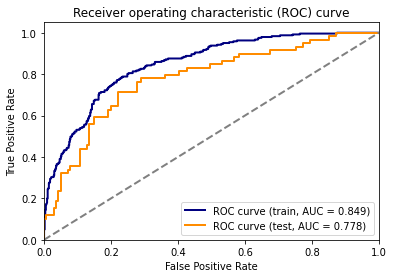

In [15]:
hpoptimizer.plot_roc(X_train, y_train, X_test, y_test, mdl=best_mdl)

#### Gain

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

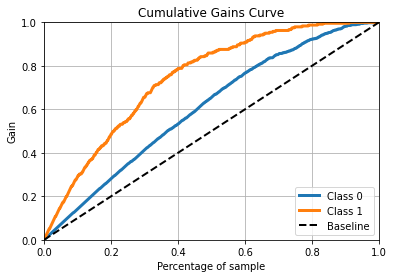

In [16]:
skplt.metrics.plot_cumulative_gain(y_train, y_train_pred)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

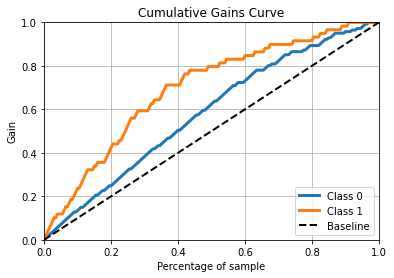

In [17]:
skplt.metrics.plot_cumulative_gain(y_test, y_test_pred)

#### Lift

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

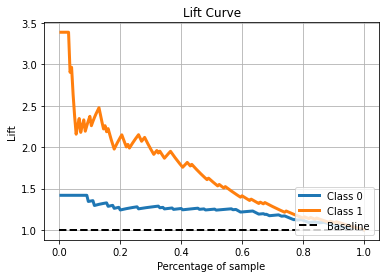

In [18]:
skplt.metrics.plot_lift_curve(y_test, y_test_pred)

#### KS Statistic

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

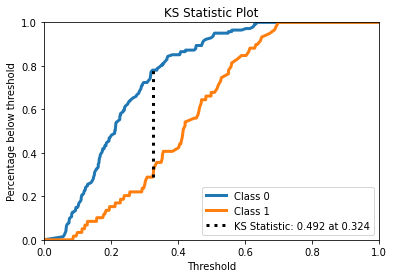

In [19]:
skplt.metrics.plot_ks_statistic(y_test, y_test_pred)

#### Precision-Recall

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

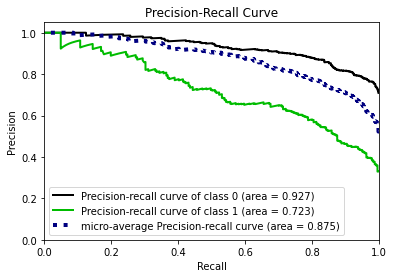

In [20]:
skplt.metrics.plot_precision_recall(y_train, y_train_pred)

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

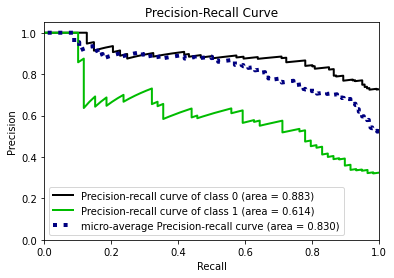

In [21]:
skplt.metrics.plot_precision_recall(y_test, y_test_pred)

### 5.2. Calibration

<AxesSubplot:title={'center':'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>

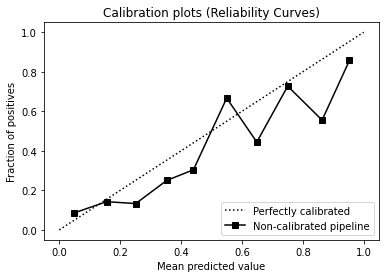

In [22]:
skplt.metrics.plot_calibration_curve(y_test,
                                     [y_test_pred],
                                     ['Non-calibrated pipeline'])

### 5.3. HyperOpt Convergence

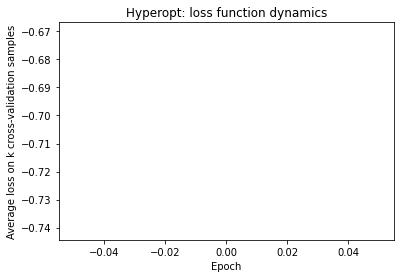

In [23]:
hpoptimizer.plot_convergence()